<a href="https://colab.research.google.com/github/DrAlexSanz/neural_machine_translation/blob/master/Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf "/content/neural_machine_translation"

!git clone https://github.com/DrAlexSanz/neural_machine_translation.git


Cloning into 'neural_machine_translation'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
%cd "/content/neural_machine_translation"

/content/neural_machine_translation


In [3]:
!pip install Faker

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda

from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.models import load_model, Model
from keras.callbacks import History

import keras.backend as K

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date

from nmt_utils import *

print("Everything imported correctly")

Everything imported correctly


Now let's load the dataset, 1e4 dates with this structure.

* dataset: a list of tuples of (human readable date, machine readable date)
* human_vocab: a python dictionary mapping all characters used in the human readable dates to an integer-valued index
machine_vocab: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with human_vocab.
* inv_machine_vocab: the inverse dictionary of machine_vocab, mapping from indices back to characters.



In [5]:
m = 10000 # 1e4 is a float, not an int.
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 22652.95it/s]


In [6]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

In [7]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': 36,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

In [8]:
machine_vocab

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [9]:
inv_machine_vocab

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long).

In [0]:
Tx = 30
Ty = 10

X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

In [11]:
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
print("Xoh.shape = ", Xoh.shape)
print("Yoh.shape = ", Yoh.shape)

X.shape =  (10000, 30)
Y.shape =  (10000, 10)
Xoh.shape =  (10000, 30, 37)
Yoh.shape =  (10000, 10, 11)


This is

* X: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via human_vocab. Each date is further padded to $T_x$ values with a special character (< pad >). X.shape = (m, Tx)
* Y: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in machine_vocab. You should have Y.shape = (m, Ty).
* Xoh: one-hot version of X, the "1" entry's index is mapped to the character thanks to human_vocab. Xoh.shape = (m, Tx, len(human_vocab))
* Yoh: one-hot version of Y, the "1" entry's index is mapped to the character thanks to machine_vocab. Yoh.shape = (m, Tx, len(machine_vocab)). Here, len(machine_vocab) = 11 since there are 11 characters ('-' as well as 0-9).

In [12]:
index = 0

print("Source date = ", dataset[index][0])
print("Target date = ", dataset[index][1])

print("Source (after preprocessing)", X[index])
print("Target (after preprocessing)", Y[index])

print("Source oh (after preprocessing)", Xoh[index])
print("Target oh (after preprocessing)", Yoh[index])

Source date =  9 may 1998
Target date =  1998-05-09
Source (after preprocessing) [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target (after preprocessing) [ 2 10 10  9  0  1  6  0  1 10]
Source oh (after preprocessing) [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target oh (after preprocessing) [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Neural machine translation with attention

I know, the attention mechanism is "just" the method we use to tell the network which part of the sentence to pay attention to. Like the human translator.

Attention mechanism
In this part, you will implement the attention mechanism presented in the lecture videos. Here is a figure to remind you how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$).

</table>
Here are some properties of the model that you may notice:

There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes before the attention mechanism, we will call it pre-attention Bi-LSTM. The LSTM at the top of the diagram comes after the attention mechanism, so we will call it the post-attention LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps.

The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM.

The diagram on the right uses a RepeatVector node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then Concatenation to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use RepeatVector and Concatenation in Keras below.

Lets implement this model. You will start by implementing two functions: one_step_attention() and model().

1) one_step_attention(): At step $t$, given all the hidden states of the Bi-LSTM ($[a^{&lt;1&gt;},a^{&lt;2&gt;}, ..., a^{&lt;T_x&gt;}]$) and the previous hidden state of the second LSTM ($s^{&lt;t-1&gt;}$), one_step_attention() will compute the attention weights ($[\alpha^{&lt;t,1&gt;},\alpha^{&lt;t,2&gt;}, ..., \alpha^{&lt;t,T_x&gt;}]$) and output the context vector (see Figure 1 (right) for details):$$context^{&lt;t&gt;} = \sum_{t' = 0}^{T_x} \alpha^{&lt;t,t'&gt;}a^{&lt;t'&gt;}\tag{1}$$

Note that we are denoting the attention in this notebook $context^{\langle t \rangle}$. In the lecture videos, the context was denoted $c^{\langle t \rangle}$, but here we are calling it $context^{\langle t \rangle}$ to avoid confusion with the (post-attention) LSTM's internal memory cell variable, which is sometimes also denoted $c^{\langle t \rangle}$.

2) model(): Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{&lt;1&gt;},a^{&lt;2&gt;}, ..., a^{&lt;T_x&gt;}]$. Then, it calls one_step_attention() $T_y$ times (for loop). At each iteration of this loop, it gives the computed context vector $c^{&lt;t&gt;}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{&lt;t&gt;}$.

Exercise: Implement one_step_attention(). The function model() will call the layers in one_step_attention() $T_y$ using a for-loop, and it is important that all $T_y$ copies have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras:

Define the layer objects (as global variables for examples).
Call these objects when propagating the input.
We have defined the layers you need as global variables. Please run the following cells to create them. Please check the Keras documentation to make sure you understand what these layers are: RepeatVector(), Concatenate(), Dense(), Activation(), Dot().

In [13]:
#Define the shared layers as global variables.

repeator = RepeatVector(Tx)
concatenator = Concatenate(axis = -1)
densor = Dense(1, activation = "relu") # This is a dense with 1 neuron, don't lose track.
activator = Activation(softmax, name = "attention_weights")
dotor = Dot(axes = 1)

In [0]:
def one_step_attention(a, s_prev):
    """
    This function computes the context vector for one step.
    The context vector is the dot product of the attention weights (alphas) and the hidden states (a) of the BiLSTM
    
    Inputs: Obviously, the hidden states output a. Shape (m, Tx, 2 * n_a) because it's a BIdirectional network, there are two components. If it is a N-directional, then a factor of N.
            s_prev = previous hidden states of the post attention LSTM. Shape (m, n_s)
            
    Output: context. Input of the next post attention LSTM cell
    """
    
    # By using the previous repeator layer that I defined, I repeat s_prev to have the shape (m, Tx, n_s)
    
    s_prev = repeator(s_prev)
    
    # Concat. Now the tensor has dimensions (m, Tx, 2 * n_a + n_s)
    concat = concatenator([a, s_prev])
    
    # Pass through the dense layer to compute the "energies"
    
    e = densor(concat)
    
    # Now pass it through the softmax activation for the attention weights
    alphas = activator(e)
    
    # Finally, multiply the alphas by the hidden states
    
    context = dotor([alphas, a])
    
    return context

Again, let's define some "global" layers for use later.

In [0]:
n_a = 64
n_s = 128

post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation = "softmax")

Now you can use these layers $T_y$ times in a for loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps:

Propagate the input into a Bidirectional LSTM
Iterate for $t = 0, \dots, T_y-1$:

* Call one_step_attention() on $[\alpha^{&lt;t,1&gt;},\alpha^{&lt;t,2&gt;}, ..., \alpha^{&lt;t,T_x&gt;}]$ and $s^{&lt;t-1&gt;}$ to get the context vector $context^{&lt;t&gt;}$.
* Give $context^{&lt;t&gt;}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using initial_state= [previous hidden state, previous cell state]. Get back the new hidden state $s^{&lt;t&gt;}$ and the new cell state $c^{&lt;t&gt;}$.
* Apply a softmax layer to $s^{&lt;t&gt;}$, get the output.
* Save the output by adding it to the list of outputs.
* Create your Keras model instance, it should have three inputs ("inputs", $s^{&lt;0&gt;}$ and $c^{&lt;0&gt;}$) and output the list of "outputs".

In [0]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Input: Tx, length of input sequence
           Ty, length of output sequence
           n_a, size of the hidden state of the BiLSTM
           n_s, size of the post attention LSTM cell
           human_vocab_size is the size of the human_vocab size
           machine_vocab_size is the size of the machine vocab
    
    Output: model. A keras model instance 
    
    """
    # Define the model input size (Tx,)
    # Define the initial hidden state for the LSTM cell (s0, c0), shape (n_s,)
    
    X = Input(shape = (Tx, human_vocab_size))
    s0 = Input(shape = (n_s,), name = "s0")
    c0 = Input(shape = (n_s,), name = "c0")
    
    s = s0
    c = c0
    
    # Initialize ouputs list
    outputs = []
    
    # Define the pre-attention LSTM
    
    a = Bidirectional(LSTM(n_a, return_sequences = True))(X)
    
    # Iterate for Ty steps
    
    for t in range(Ty):
        context = one_step_attention(a, s)
        
        # Apply post-attention LSTM to the context vector
        # Pass initial_state = [hidden state, cell state]
        s, _, c = post_activation_LSTM_cell(context, [s, c])
        
        out = output_layer(s)
        outputs.append(out)
        
    model = Model([X, s0, c0], outputs)
    
    return model
    
    

Now create the model and see the summary.

In [17]:
my_model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
my_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 128)      52224       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 128)      0           s0[0][0]                         
                                                                 lstm_1[0][0]             

Looks ok. Let's plot it to see if it explodes or not.

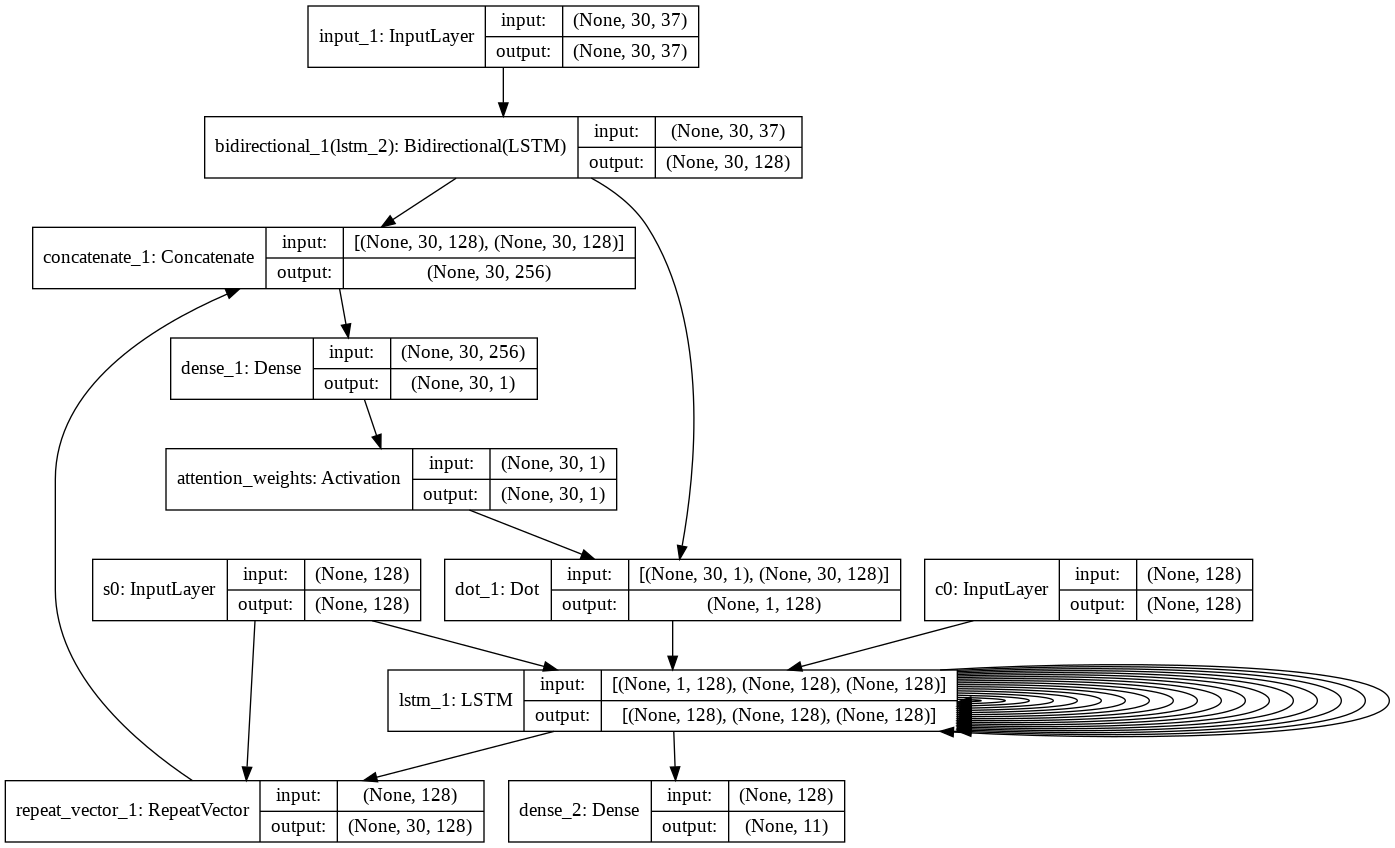

In [18]:
plot_model(my_model, to_file = "plotting.png", show_shapes = True)

The recurrence is a bit tricky to plot but still, I can see that it works. Let's compile and train.

In [19]:
opti = Adam(lr = 5e-3, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
hist = History()

my_model.compile(optimizer = opti, metrics = ["accuracy"], loss = "categorical_crossentropy")

In [0]:
# Let's initialize the inputs and fit the model.

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0, 1))

In [21]:
num_epochs = 20
b_s = 100

my_model.fit([Xoh, s0, c0], outputs, epochs = num_epochs, batch_size = b_s, callbacks = [hist])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
10000/10000 [==============================] - 24s 2ms/step - loss: 14.9623 - dense_2_loss: 2.4956 - dense_2_acc: 0.5348 - dense_2_acc_1: 0.7383 - dense_2_acc_2: 0.3758 - dense_2_acc_3: 0.1119 - dense_2_acc_4: 0.9264 - dense_2_acc_5: 0.4759 - dense_2_acc_6: 0.1255 - dense_2_acc_7: 0.8942 - dense_2_acc_8: 0.3076 - dense_2_acc_9: 0.1173
Epoch 2/20
10000/10000 [==============================] - 16s 2ms/step - loss: 6.7471 - dense_2_loss: 1.8246 - dense_2_acc: 0.9681 - dense_2_acc_1: 0.9716 - dense_2_acc_2: 0.7610 - dense_2_acc_3: 0.4328 - dense_2_acc_4: 0.9998 - dense_2_acc_5: 0.9393 - dense_2_acc_6: 0.5037 - dense_2_acc_7: 0.9999 - dense_2_acc_8: 0.6245 - dense_2_acc_9: 0.3203
Epoch 3/20
10000/10000 [==============================] - 15s 2ms/step - loss: 3.9154 - dense_2_loss: 1.2066 - dense_2_acc: 0.9792 - dense_2_acc_1: 0.9808 - dense_2_acc_2: 0.8606 - dense_2_acc_3: 0.7597 - dense

In [22]:
print(hist.history.keys())

dict_keys(['loss', 'dense_2_loss', 'dense_2_acc', 'dense_2_acc_1', 'dense_2_acc_2', 'dense_2_acc_3', 'dense_2_acc_4', 'dense_2_acc_5', 'dense_2_acc_6', 'dense_2_acc_7', 'dense_2_acc_8', 'dense_2_acc_9'])


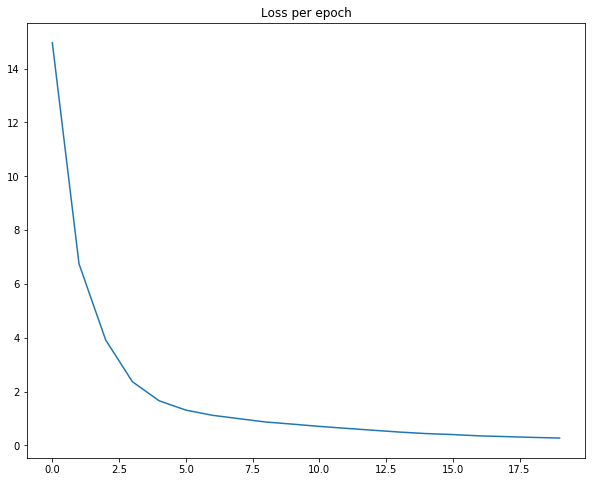

In [23]:
plt.figure(figsize = (10,8))
plt.title("Loss per epoch")
plt.plot(range(num_epochs), list(hist.history.values())[0])

Now to test the model.

In [39]:
with tf.Session() as test:

    Examples = ["3 May 1979", "5 April 09", "21th of August 2016", "Tue 10 Jul 2007", "Saturday May 9 2018", "March 3 2001", "March 3rd 2001", "1 March 2001"]

    for example in Examples:
        source = string_to_int(example, Tx, human_vocab)
        source = np.array(list(map(lambda x: to_categorical(x, num_classes = len(human_vocab)), source))).swapaxes(0,1)
#         source = K.expand_dims(source, axis = 0).eval()
        prediction = my_model.predict([source, s0, c0])
        prediction = np.argmax(prediction, axis = -1)
        output = [inv_machine_vocab[int(i)] for i in prediction]

        print("Source: ", example)
        print("Prediction: ", " ".join(output))

ValueError: ignored